# 时序预测与异常检测
- **Import Some Packages**: 导入一些必要的包
- **Set Functions and Params**: 设置一些必要的函数：随机种子、选择gpu
- **Data Process**: 数据收集，格式转换，数据预处理（数据清洗：处理缺失值。
  异常值数据转换：如对数转换，归一化等，以稳定数据的方差(此处应该是两部分包括异常之检测和异常值处理)）
- **Data Analysis**: 数据分析：分析数据的特征，如季节性、趋势、周期性等，这一步是重要的你的模型的效果好坏可能百分之60来源于模型，另外的百分之40就来源于这一步

- **Set Dataset**: 划分数据集，设置dataset，设置dataloader
- **Set DataLoader**
- **Set Model**：选择模型
- **train/dev/test**: 编写训练/验证/测试函数
- **Start train**
- **Start predict**
- **Plot**
- **Model evaluation**

## Import Some Packages

In [51]:
# Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft, fftfreq
from scipy.signal import detrend
from statsmodels.tsa.stattools import adfuller
import torch
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
from torch.nn.utils import weight_norm

# For txt
import sys

# For data preprocess
import numpy as np
import csv
import os
from sklearn.preprocessing import MinMaxScaler
import math

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import matplotlib

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# for 数据分析
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

# 使用系统中的中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 或其他你确认支持中文的字体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

## Set Functions and Params

In [2]:
# hyperparameter
config = {
    'n_epochs': 5,                # maximum number of epochs
    'batch_size': 300,               # mini-batch size for dataloader
    'optimizer': 'Adam',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 1e-3,                 # learning rate
        # 'momentum': 0.9              # momentum
        'weight_decay': 1e-5        # weight_decay
    },
    'model':{
        'kernel_sizes':3,
        'model_dim':[64, 128, 256],#这个地方是这个TCN卷积的关键部分,它代表了TCN的层数我这里输入list中包含三个元素那么我的TCN就是三层，这个根据你的数据复杂度来设置层数越多对应数据越复杂但是不要超过5层

    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth' , # your model will be saved here
    'fig_path': 'fig/',
    'fig_type': 'png',
    'window_len':100*2,                   # T = 100
    'window_step':1,
    'pre_len':20, 
    'future':100*2+20*5,
    # 'future':20*5,
    'seed':5201314,
    'valid_ratio': 0.3,
    'param_beta':1.0
}
myseed = config['seed']
# Set Random Seed
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
same_seed(myseed)

def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
# 归一化处理
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
 
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)
 
    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std
 
    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        # if data.shape[-1] != mean.shape[-1]:
        #     mean = mean[-1:]
        #     std = std[-1:]
        return (data * std) + mean
    


# 绘制Loss图像
def plot_loss_data(data):
    # 使用Matplotlib绘制线图
    plt.figure()
 
    plt.plot(data, marker='o')
 
    # 添加标题
    plt.title("loss results Plot")
 
    # 显示图例
    plt.legend(["Loss"])
 
    plt.show()

## RevIN

In [3]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: 特征或通道的数量
        :param eps: 数值稳定性参数，防止除零错误
        :param affine: 如果为True，RevIN有可学习的仿射参数
        :param subtract_last: 如果为True，减去最后一个时间步的值
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str, mask=None):
        if mode == 'norm':
            self._get_statistics(x, mask)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):
        # 初始化RevIN参数: (M,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x, mask=None):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


## Data Process

In [5]:
# 导入数据
path_SL = 'Data/statlink01_orbit.txt'
path_Lunar = 'Data/Lunar_Vector_J2000.txt'
path_Sun = 'Data/Sun_Vector_J2000.txt'

def datacatcher(path,idx_start,idx_end,line_pass):
    f = open(path , encoding='utf-8')
    line = f.readline()
    list = []
    count = 0
    while line:
        if(count%line_pass == 0):
            a = line.split(" ")            #将数据以空格的方式分隔开
            b = a[idx_start:idx_end]              #这就是选择前四行保存下来（如果想保存第2，3行就写成b = a[1,3]）即可
            list.append(b)
            # list.append('\n')
        line = f.readline()
        count = count+1
    f.close()
    data_array=np.array(list)
    return data_array.astype(float)
data_SL_raw = datacatcher(path_SL,0,4,4)
data_Lunar = datacatcher(path_Lunar,4,7,1)
data_Sun = datacatcher(path_Sun,4,7,1)
time_stand = 2024250000000.000
data_time = data_SL_raw[:,:1]-time_stand
data_SL = data_SL_raw[:,1:]# 除去时间特征
slide_step = 1
# Dataset_raw = np.hstack((data_time, data_Sun,data_Lunar, data_SL))#
Dataset_raw = np.hstack((data_SL[:-1*slide_step,:],data_SL[1*slide_step:,:]))#
Dataset_raw = Dataset_raw[:,0]
print(type(Dataset_raw))
print(Dataset_raw.shape)
print(Dataset_raw.ndim)

# 异常值处理
def OutlierProcessing(data):
    # print("原始数据:", data)
    # 处理数据中的Nan值
    window_size = 5
    threshold = 3
    moving_avg = np.empty_like(data)
    # 使用 np.nanmean 计算滚动平均
    for i in range(len(data)):
        if i < window_size:
            moving_avg[i] = np.nanmean(data[:i + 1])
        else:
            moving_avg[i] = np.nanmean(data[i - window_size + 1:i + 1])
    # 替换原始数据中的 NaN 值为对应的移动平均值
    data[np.isnan(data)] = moving_avg[np.isnan(data)]  # 或者 data = np.where(np.isnan(data), moving_avg, data)
    # 计算 Z-score
    mean = np.nanmean(data)
    std_dev = np.nanstd(data)
    z_scores = (data - mean) / std_dev
    # 检测异常值
    outliers = np.abs(z_scores) > threshold

    # 使用移动平均值替换异常值
    data[outliers] = moving_avg[outliers] # 会提取 data 数组中所有被标记为异常值的位置，得到的是异常值对应的数据。

    # 输出结果

    # print("移动平均:", moving_avg)
    # print("Z-score:", z_scores)
    # print("异常值的掩码:", outliers)
    # print("替换后的数据:", data)
    return data
Dataset_raw = OutlierProcessing(Dataset_raw)


<class 'numpy.ndarray'>
(4320,)
1


## Data Analysis 

In [39]:
# 1. 读取CSV文件
def read_csv_data(file_path):
    data = pd.read_csv(file_path, header=None, names=['timestamp', 'value'])
    return data

# 2. 绘制基本图像
def plot_basic_image(data):
    plt.figure(figsize=(30,2))
    plt.plot(data['timestamp'],data['value'], label='Original Data',color=seaborn.xkcd_rgb['wine red'],linewidth = 3)
    # plt.plot(np.arange(len(data['value'])),data['value'], label='Original Data',color=seaborn.xkcd_rgb['wine red'])
    # plt.plot(np.arange(data['value']), data['value'], label='Original Data')
    plt.title('Original Time Series Data',fontsize=26)
    plt.xlabel('timestamp',fontsize=24)
    plt.ylabel('value',fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc="upper right",fontsize=12)
    plt.grid(True)
    plt.show()
# 2. 绘制基本图像
def plot_image(data):
    plt.figure(figsize=(30,10))
    plt.plot(np.arange(len(data)),data, label='Original Data',color=seaborn.xkcd_rgb['wine red'])
    # plt.plot(np.arange(data['value']), data['value'], label='Original Data')
    plt.title('Original Time Series Data',fontsize=18)
    plt.xlabel('timestamp',fontsize=16)
    plt.ylabel('value',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# 异常值处理
def process_timestamp_series(file_path, output_dir='data/中10-位保数据-LY/中星10号推力器相关遥测数据/all_timestamp', threshold=2.4):
    
    # 读取CSV文件中的时序数据
    file_name = os.path.splitext(os.path.basename(file_path))[0]  # 获取不带扩展名的文件名
    df = pd.read_csv(file_path, header=None, names=['timestamp', 'value'])

    # 解析时间戳
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 设置时间戳为索引
    df.set_index('timestamp', inplace=True)

    # 创建保存目录（如果不存在则创建）
    missing_values_dir = os.path.join(output_dir, 'missing_values')
    interpolated_data_dir = os.path.join(output_dir, 'interpolated_data')
    plots_dir = os.path.join(output_dir, 'plots')

    os.makedirs(missing_values_dir, exist_ok=True)
    os.makedirs(interpolated_data_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)

    # 检查原始文件中的空缺值，记录空缺值的索引并保存到指定文件夹
    missing_values = df[df['value'].isna()]
    missing_values_output_path = os.path.join(missing_values_dir, file_name + '_missing_indices.csv')
    missing_values.to_csv(missing_values_output_path, index=False, header=False)

    # 使用Z-score的方法去除野值
    def remove_outliers_zscore(df, column, threshold=3):
        mean = df[column].mean()
        std = df[column].std()
        z_scores = (df[column] - mean) / std
        return df[np.abs(z_scores) < threshold]

    # 去除野值（Z-score 方法）
    df_cleaned_zscore = remove_outliers_zscore(df, 'value', threshold)

    # 使用线性插值填充数据中的空缺值
    df_interpolated = df_cleaned_zscore.interpolate(method='linear')

    # 将插值处理后的数据保存到指定文件夹
    interpolated_output_path = os.path.join(interpolated_data_dir, file_name + '.csv')
    df_interpolated.to_csv(interpolated_output_path, index=True, header=False)

    # 显示原始数据、插值后的数据和去除野值后的数据对比
    plt.figure(figsize=(18, 30))

    # 原始数据
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['value'], label='Original Data')
    plt.xlabel('timestamp',fontsize=24)
    plt.ylabel('value',fontsize=24)
    plt.title(file_name,fontsize=30)  # 使用文件名作为图的标题
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # 插值后的数据
    plt.subplot(3, 1, 3)
    plt.plot(df_interpolated.index, df_interpolated['value'], label='Interpolated Data', color=seaborn.xkcd_rgb['baby poop green'])
    plt.xlabel('timestamp',fontsize=24)
    plt.ylabel('value',fontsize=24)
    plt.title('timestamp Series Data After Interpolation',fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Z-score 方法去除野值后的数据
    plt.subplot(3, 1, 2)
    plt.plot(df_cleaned_zscore.index, df_cleaned_zscore['value'], label='Z-score Cleaned Data', color=seaborn.xkcd_rgb['powder blue'])
    plt.xlabel('timestamp',fontsize=24)
    plt.ylabel('value',fontsize=24)
    plt.title('timestamp Series Data After Removing Outliers (Z-score)',fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    plt.tight_layout()

    # 保存图像到指定文件夹
    output_image_path = os.path.join(plots_dir, file_name + '.png')
    plt.savefig(output_image_path)

    plt.show()
    return df_cleaned_zscore


# 3. 小波分析
def wavelet_analysis(data):
    coeffs = pywt.wavedec(data['value'], 'db4', level=5)
    
    plt.figure(figsize=(12, 8))
    for i, coeff in enumerate(coeffs):
        plt.subplot(len(coeffs), 1, i+1)
        plt.plot(coeff)
        plt.title(f'Detail Level {i}')
    plt.tight_layout()
    plt.show()

# 4. 快速傅里叶变换（FFT）
def fft_analysis(data):
    # 将时间列转换为 datetimestamp 类型，确保包含日期和毫秒
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # 计算数据长度 N
    N = len(data['value'])
    
    # 计算时间间隔 T，使用 total_seconds() 来处理包含毫秒的时间差
    total_timestamp_seconds = (data['timestamp'].iloc[-1] - data['timestamp'].iloc[0]).total_seconds()
    T = total_timestamp_seconds / N
    
    # 确保 data['value'] 是 NumPy 数组
    value_array = np.array(data['value'])
    
    # 进行 FFT 计算
    yf = fft(value_array)
    
    # 计算频率数组 xf，只取前 N//2 的部分（因为 FFT 结果是对称的）
    xf = fftfreq(N, T)[:N//2]
    
    # 绘制 FFT 结果
    plt.figure(figsize=(30,5))
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]),linewidth = 3)
    plt.xlim(-0.5e-7,0.001)
    # plt.ylim(-0.5, 1)
    plt.title('FFT of the timestamp Series Data',fontsize=28)
    plt.xlabel('Frequency (Hz)',fontsize=24)
    plt.ylabel('Amplitude',fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.show()

# 5. 分布漂移检测（ADF测试）
def distribution_drift_detection(data):
    result = adfuller(data['value'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] > 0.05:
        print("The timestamp series is non-stationary (i.e., has distribution drift).")
    else:
        print("The timestamp series is stationary (i.e., no distribution drift).")

2023-01-01 00:00:00    1224.204630
2023-01-01 00:01:00     892.091252
2023-01-01 00:02:00     555.950062
2023-01-01 00:03:00     217.298556
2023-01-01 00:04:00    -122.334005
Freq: min, dtype: float64


C:\Users\zps\AppData\Local\Temp\ipykernel_25192\1480614045.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(start='2023-01-01', periods=len(Dataset_raw), freq='T')  # 生成对应日期


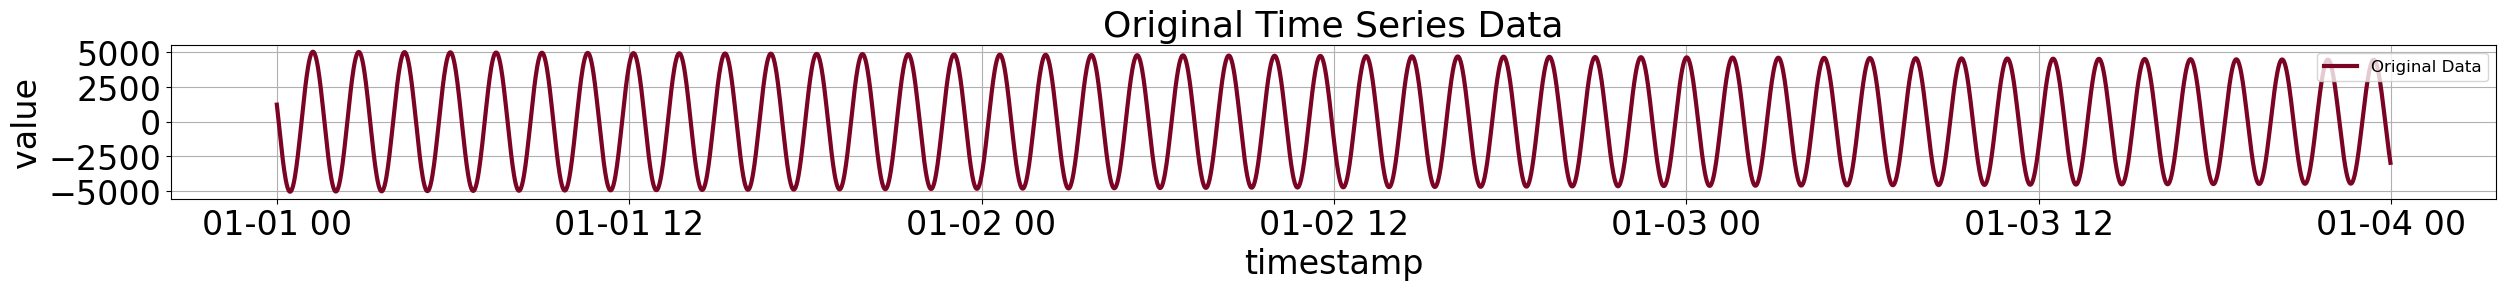

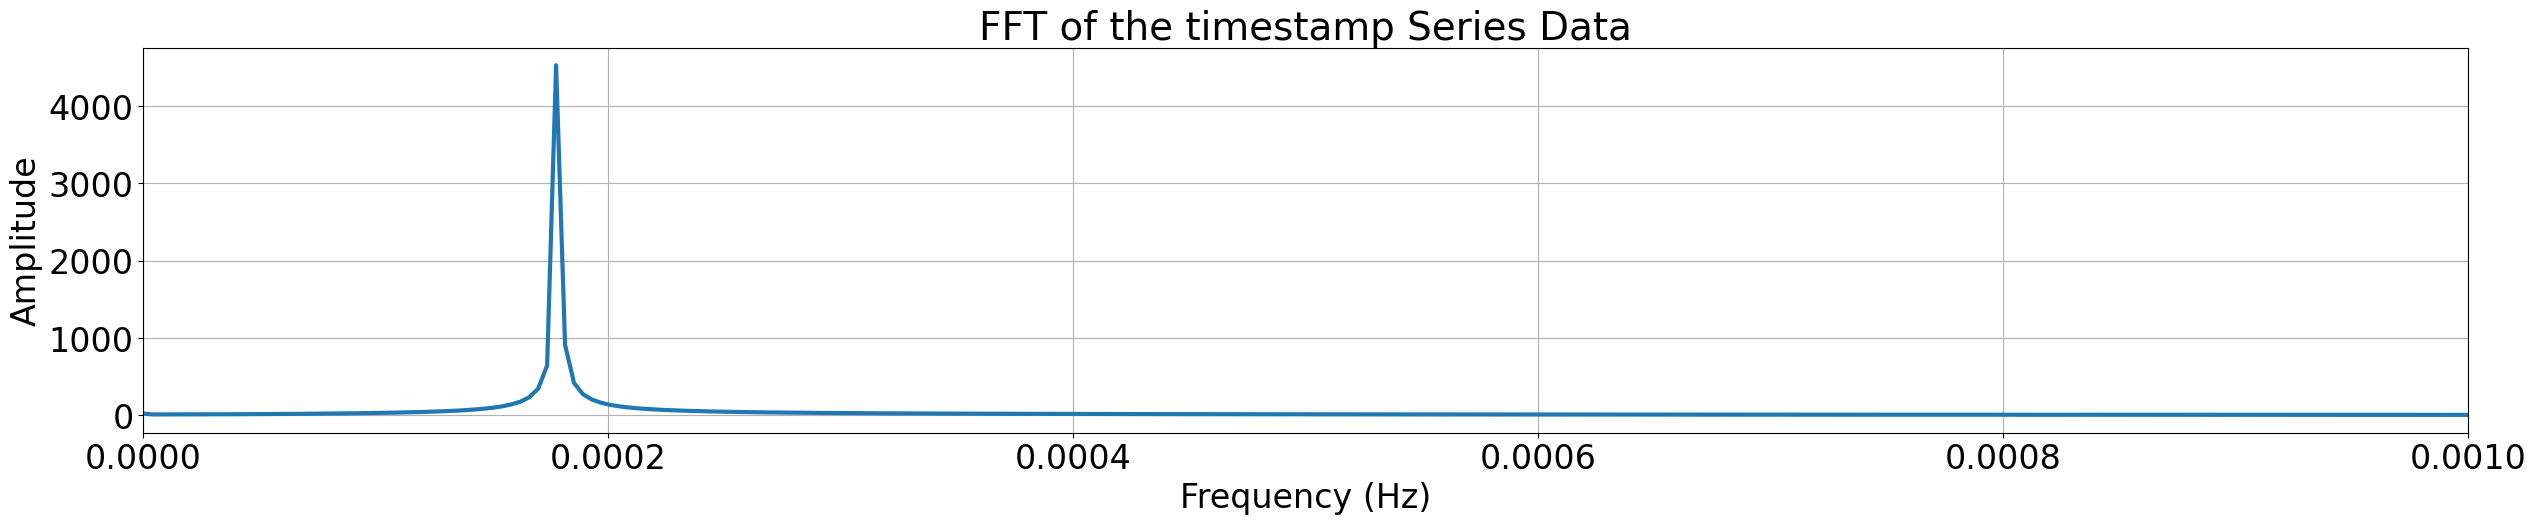

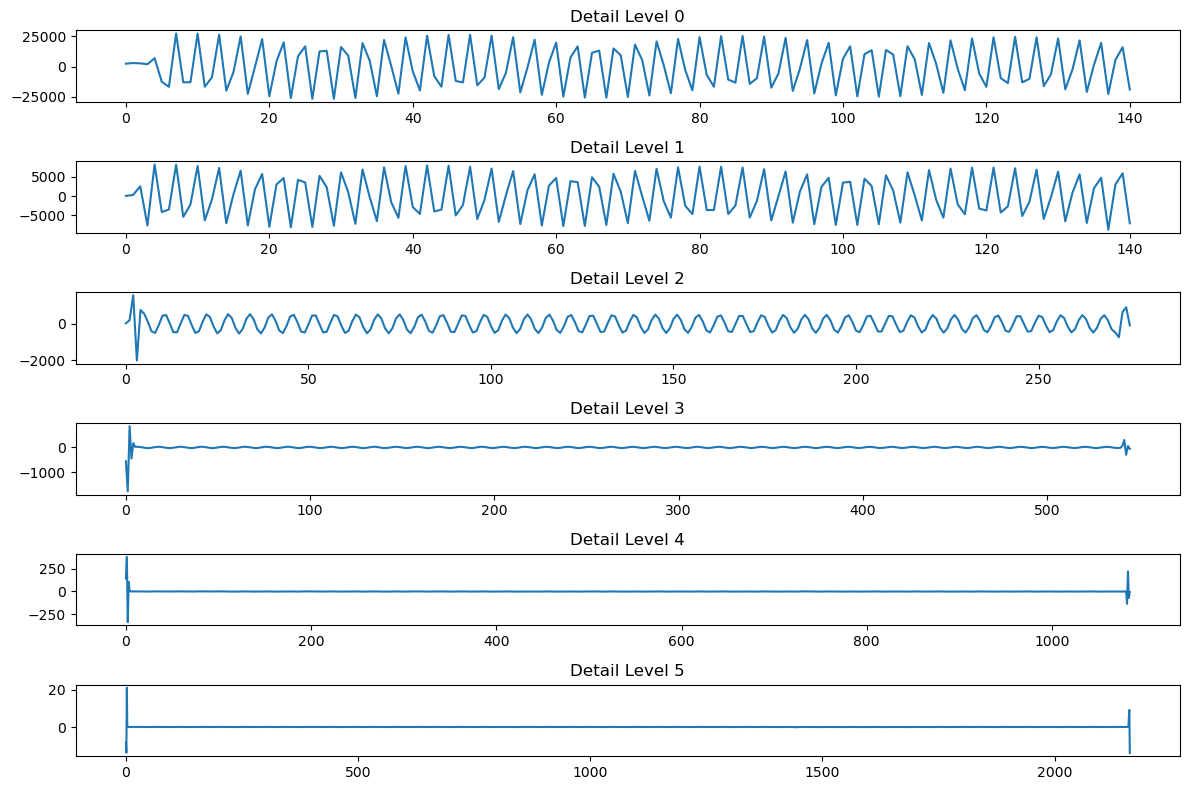

In [43]:
# 使用 Pandas 创建时间序列
dates = pd.date_range(start='2023-01-01', periods=len(Dataset_raw), freq='T')  # 生成对应日期
series = pd.Series(Dataset_raw, index=dates)
print(series.head())

# 将 Series 转换为 DataFrame
df = series.reset_index()
df.columns = ['timestamp', 'value']

# 确保 'timestamp' 列是 datetime 类型
df['timestamp'] = pd.to_datetime(df['timestamp'])
# 绘制基本图像
plot_basic_image(df)
# 快速傅里叶变换
fft_analysis(df)
# 小波分析
wavelet_analysis(df)

ADF 统计量: -33.5344
p 值: 0.0000
临界值:
	 1%: -3.432
	 5%: -2.862
	 10%: -2.567
拒绝原假设：时间序列是平稳的


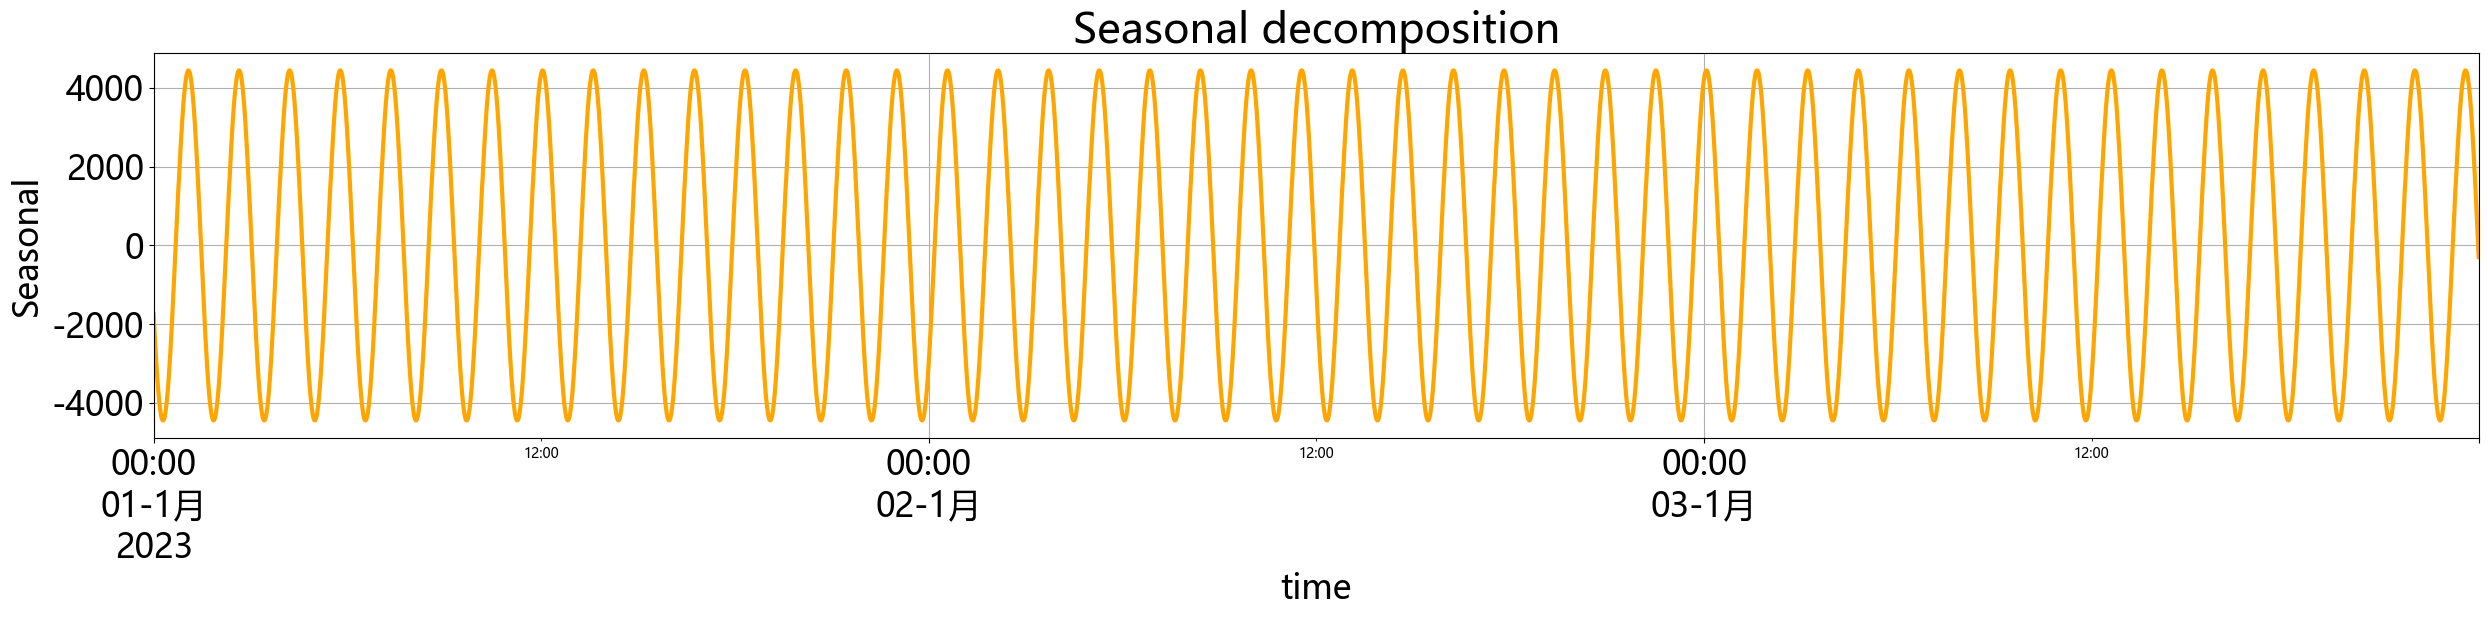

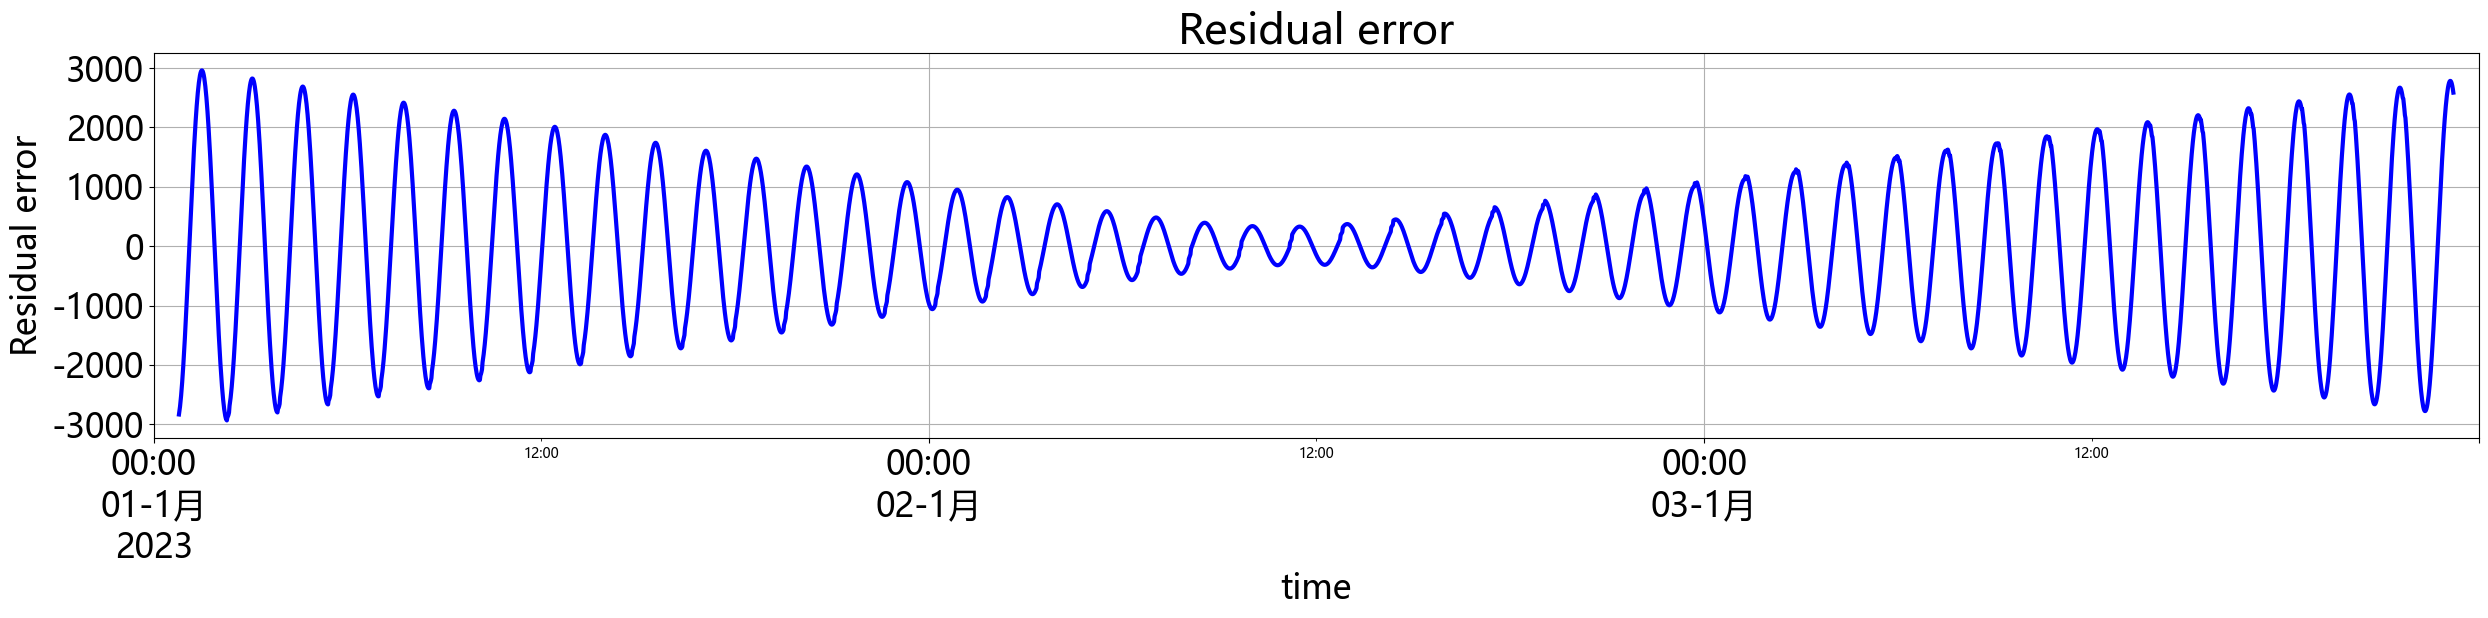

In [56]:

# # 绘制数据图像大体观察一下
# plt.figure(figsize=(12, 6))
# plt.plot(Dataset_raw)
# plt.title('Data after outliers are processed')
# plt.grid()
# plt.tight_layout()
# plt.show()
# # 估计周期（简单方法，通过估计自相关）
# def estimate_period(data):
#     lag = 1
#     autocorr = []
    
#     while lag < len(data) // 2:
#         corr = np.corrcoef(data[:-lag], data[lag:])[0, 1]  # 计算自相关
#         autocorr.append(corr)
#         lag += 1
    
#     return np.argmax(autocorr) + 1  # 返回自相关最大的滞后值（周期）

# estimated_period = estimate_period(series)  # 仅使用有效数据
# print(f'T={estimated_period }')
# 进行季节性分解
decomposition = seasonal_decompose(series, model='additive', period=int(94))

# 季节性分析图
plt.figure(figsize=(30, 5))
decomposition.seasonal.plot(ax=plt.gca(), label='Seasonal decomposition', color='orange',linewidth = 3)
plt.title('Seasonal decomposition',fontsize = 30)
plt.xlabel('time',fontsize = 24)
plt.ylabel('Seasonal',fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

plt.grid()

# 残差图
plt.figure(figsize=(30, 5))
decomposition.resid.plot(ax=plt.gca(), label='Residual error', color='blue',linewidth = 3)
plt.title('Residual error',fontsize = 30)
plt.xlabel('time',fontsize = 24)
plt.ylabel('Residual error',fontsize = 24)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

plt.grid()

# 平稳性检验
# ADF 检验
adf_result = adfuller(series.dropna())  # 清除 NaN 值进行检验
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# 打印 ADF 检验结果
print('ADF 统计量: {:.4f}'.format(adf_statistic))
print('p 值: {:.4f}'.format(p_value))
print('临界值:')
for key in critical_values.keys():  # 结果中的每个关键字都是单独的
    print('\t {}: {:.3f}'.format(key, critical_values[key]))

# 检验结论
if p_value < 0.05:
    print('拒绝原假设：时间序列是平稳的')
else:
    print('不能拒绝原假设：时间序列具有单位根，非平稳')

## Set Dataset

In [20]:
# 数据集划分
def train_valid_split(data_set,valid_ratio,seed):
    test_data = data_set[3200:]   # 1320
    train_data = data_set[:2600] # 2600
    valid_data = data_set[2600:3200] # 600
    print(f'size of test_data is {test_data.shape}')
    print(f'size of train_data is {train_data.shape}')
    print(f'size of valid_data is {valid_data.shape}')
    return np.array(train_data).astype(float),np.array(valid_data).astype(float),np.array(test_data).astype(float)
# 构造数据集
class TimeSeriesDataset(Dataset):
    # input:数据路径；模式（默认为train）；特征选择
    def __init__(self,
                 data,
                 label,
                 mode='train'):
        # Determine the mode
        self.mode = mode
        # 检查数据类型
        # data = np.array(data)  # Convert to numpy array if not already
        # label = np.array(label)
        # print(data.dtype)  # 查看数据类型
        if mode == 'test':
            self.data = torch.FloatTensor(np.array(data))# 转化成张量
        else:
            # label = data[:, 1]
            # data = data[:, 0]
            
            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(np.array(data))
            self.label = torch.FloatTensor(np.array(label))
        self.dim = 1# 选取的是第二维度
        print('Finished reading the {} set of Orbit Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.label[index]
        else:
            # For testing (no label)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)
# 数据分割器
def create_inout_sequences(input_data, tw, pre_len, config):
    '''
    创建时间序列数据专用的数据分割器
    input_data: 输入的时间序列数据，通常是一个数组或矩阵。
    tw: 滑动窗口大小，决定了每个输入序列的长度。
    pre_len: 预测长度，即模型需要预测的未来数据点的数量。
    config: 配置对象，包含有关特征选择的信息。
    '''
    inout_seq_data = []       # 初始化：创建一个空列表 inout_seq 用于存储输入输出序列对
    inout_seq_label = []       # 初始化：创建一个空列表 inout_seq 用于存储输入输出序列对

    L = len(input_data)
    for i in range(L - tw):
        
        if (i + tw + pre_len) < len(input_data):
            seq_data = input_data[i:i + tw] # 在每个迭代中，提取当前的输入序列 train_seq，长度为 tw
            seq_label = input_data[i + tw:i + tw + pre_len]
            inout_seq_data.append(seq_data)
            inout_seq_label.append(seq_label)
    return inout_seq_data,inout_seq_label

## Set DataLoader

In [21]:
def create_dataloader(data, config, device):
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    # 设计超参数
    pre_len = config['pre_len']  # 预测未来数据的长度
    train_window = config['window_len']  # 观测窗口

    # 定义标准化优化器
    scaler = StandardScaler()
    scaler.fit(data)
    # 划分数据
    train_data,valid_data,test_data = train_valid_split(data,config['valid_ratio'],config['seed'])

 
    # 进行标准化处理
    train_data_normalized = scaler.transform(train_data)
    valid_data_normalized = scaler.transform(valid_data)
    test_data_normalized = scaler.transform(test_data)

    print(f'train_data_normalized  is {train_data_normalized.shape}')
    print(f'valid_data_normalized is {valid_data_normalized.shape}')
    print(f'test_data_normalized is {test_data_normalized.shape}')
    # 定义训练器的的输入
    train_data,train_label = create_inout_sequences(train_data_normalized, train_window, pre_len, config)
    valid_data,valid_label = create_inout_sequences(valid_data_normalized, train_window, pre_len, config)
    test_data,test_label  = create_inout_sequences(test_data_normalized,  train_window, pre_len, config)
    # print(f'{test_inout_seq} ' )
    # print(f'{train_inout_seq} ')
    # print(f'{valid_inout_seq} ')
    # print(f'test_inout_seq  is {len(test_inout_seq)}')
    # print(f'train_inout_seq is {len(train_inout_seq)}')
    # print(f'valid_inout_seq is {len(valid_inout_seq)}')
    # 创建数据集
    train_dataset = TimeSeriesDataset(train_data,train_label,'train')
    valid_dataset = TimeSeriesDataset(valid_data,valid_label,'dev')
    test_dataset = TimeSeriesDataset(test_data,test_label,'test')
    # 创建 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, drop_last=True)
    
    print("通过滑动窗口共有训练集数据：", len(train_data), "转化为批次数据:", len(train_loader))
    print("通过滑动窗口共有验证集数据：", len(valid_data), "转化为批次数据:", len(valid_loader))
    print("通过滑动窗口共有测试集数据：", len(test_data), "转化为批次数据:", len(test_loader))
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器完成<<<<<<<<<<<<<<<<<<<<<<<<<<<")
    return train_loader, valid_loader, test_loader,  scaler,train_data,train_label,valid_data,valid_label,test_data,test_label


## Set Model

In [22]:
class Chomp1d(nn.Module):
    # Chomp1d 类用于处理卷积操作后多出来的边缘部分，确保输出的长度与输入长度匹配
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
 
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()
 
 
class TemporalBlock(nn.Module):
    # TemporalBlock 类定义了 TCN 的一个基本模块，包括两个卷积层、激活函数、丢弃层和一个残差连接
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
 
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
 
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()
 
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
 
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)
 
 
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, outputs, pre_len, num_channels, kernel_size=2, dropout=0.2):#1,1，20，[64, 128, 256]，3
        super(TemporalConvNet, self).__init__()
        layers = []
        self.pre_len = pre_len
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
 
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], outputs)

        self.criterion = nn.MSELoss(reduction='mean')
    def forward(self, x):
        # print(f"shape of xA is {x.shape}")
        # x = x.permute(0, 2, 1)
        x = self.network(x)
        # print(f"shape of xB is {x.shape}")
        x = x.permute(0, 2, 1)
        x = self.linear(x)
        x = x.permute(0, 2, 1)
        return x[:, :, -self.pre_len:]
    def cal_loss(self, pred, label):
        return self.criterion(pred, label)
    def r2_loss(self, pred, label):
        target_mean = torch.mean(label)
        ss_tot = torch.sum((label - target_mean) ** 2)
        ss_res = torch.sum((label - pred) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2

## Train/Dev/Test

In [23]:
# Training
def train(tr_set, dv_set,  model, config, device):
    n_epochs = config['n_epochs']  # Maximum number of epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=config['optim_hparas']['lr'], weight_decay=config['optim_hparas']['weight_decay'])
    min_mse = math.inf # 初始设置为无穷大math.inf也行
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    mean_train_loss = 0
    train_r2score = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:
            x = x[:, None, :]
            y = y[:, None, :]
            
            # x = x.unsqueeze(1)
            # y = y.unsqueeze(1)
            optimizer.zero_grad()               # set gradient to zero
            x, y= x.to(device), y.to(device)    # move data to device (cpu/cuda)
            pred = model(x)                     # forward pass (compute output)
            train_r2score = model.r2_loss(pred, y)
            mse_loss = model.cal_loss(pred, y)  # compute loss
            mse_loss.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())# 记录train的Loss,放在字典里面
            mean_train_loss = sum(loss_record['train'])/len(loss_record['train'])# 记录训练的loss
        # After each epoch, test your model on the validation (development) set.
        dev_mse,dev_r2score = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (Epoch = {:4d}/{:4d}, train_loss = {:.4f}, dev_loss = {:.4f})\n train_r2score = {:.4f},dev_r2score={:.4f}'
                .format(epoch + 1,config['n_epochs'], mean_train_loss, min_mse,train_r2score,dev_r2score))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            # 如果模型没有优化，就记录加一，否则清零
            early_stop_cnt += 1

        epoch += 1
        torch.cuda.empty_cache()
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return pred,min_mse, loss_record

# Validation
def dev(dv_set, model, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    dev_r2score = 0  # 初始化 dev_r2score 为默认值
    # for x, y in zip(dv_set_x,dv_set_y):                         # iterate through the dataloader
    for x,y in dv_set:
        x = x[:, None, :]
        y = y[:, None, :]
        x, y = x.to(device), y.to(device)      # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                     torch.zeros(1, 1, model.hidden_layer_size))
            pred = model(x)
            dev_r2score = model.r2_loss(pred, y)
            mse_loss = model.cal_loss(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss,dev_r2score
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

## StartTrain

In [24]:
device = get_device()                 # get the current available device ('cpu' or 'cuda')
print(device)
train_loader, valid_loader, test_loader, scaler ,train_data,train_label,valid_data,valid_label,test_data,test_label= create_dataloader(Dataset_raw, config, device)

# os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/
# model = TemporalConvNet(1,1, config['pre_len'],config['model']['model_dim'], config['model']['kernel_sizes']).float().to(device)  # Construct model and move to device




cuda
>>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
size of test_data is (1120,)
size of train_data is (2600,)
size of valid_data is (600,)
train_data_normalized  is (2600,)
valid_data_normalized is (600,)
test_data_normalized is (1120,)
Finished reading the train set of Orbit Dataset (2380 samples found, each dim = 1)
Finished reading the dev set of Orbit Dataset (380 samples found, each dim = 1)
Finished reading the test set of Orbit Dataset (900 samples found, each dim = 1)
通过滑动窗口共有训练集数据： 2380 转化为批次数据: 7
通过滑动窗口共有验证集数据： 380 转化为批次数据: 1
通过滑动窗口共有测试集数据： 900 转化为批次数据: 3
>>>>>>>>>>>>>>>>>>>>>>>>>>>>创建数据加载器完成<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [55]:
train(train_loader, valid_loader , model, config, device)

Saving model (Epoch =    1/3000, train_loss = 0.8045, dev_loss = 0.3240)
 train_r2score = 0.5082,dev_r2score=0.5612
Saving model (Epoch =    2/3000, train_loss = 0.5578, dev_loss = 0.0569)
 train_r2score = 0.7718,dev_r2score=0.9229
Saving model (Epoch =    3/3000, train_loss = 0.4081, dev_loss = 0.0419)
 train_r2score = 0.9274,dev_r2score=0.9432
Saving model (Epoch =    4/3000, train_loss = 0.3257, dev_loss = 0.0228)
 train_r2score = 0.9430,dev_r2score=0.9691
Saving model (Epoch =    5/3000, train_loss = 0.2711, dev_loss = 0.0107)
 train_r2score = 0.9563,dev_r2score=0.9855
Saving model (Epoch =    6/3000, train_loss = 0.2330, dev_loss = 0.0089)
 train_r2score = 0.9606,dev_r2score=0.9880
Saving model (Epoch =    8/3000, train_loss = 0.1833, dev_loss = 0.0058)
 train_r2score = 0.9728,dev_r2score=0.9921
Saving model (Epoch =   10/3000, train_loss = 0.1520, dev_loss = 0.0051)
 train_r2score = 0.9773,dev_r2score=0.9930
Saving model (Epoch =   12/3000, train_loss = 0.1305, dev_loss = 0.0047)

KeyboardInterrupt: 

## StartPredict

In [31]:
# del model
# # 删除当前的 model 对象。这样做是为了释放内存
model = TemporalConvNet(1,1, config['pre_len'],config['model']['model_dim'], config['model']['kernel_sizes']).float().to(device)  # Construct model and move to device
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [95]:
# Dataset_raw
test_data_raw = Dataset_raw[3200:]
test_data = test_data_raw[:config['window_len']]

print(Dataset_raw.shape)
print(test_data.shape)
test_data_raw_Tensor = torch.FloatTensor(np.array(scaler.transform(test_data_raw)))
test_data_raw_Tensor = test_data_raw_Tensor[None, None, :].to(device)
test_data = test_data_raw_Tensor[:,:,:config['window_len']]

input = test_data
# begin to predict, no need to track gradient here
preds = test_data
organized = []      #按时间窗口组织后的预测值。
errors = []         #存储预测值与真实值之间的误差。
with torch.no_grad():
    for i in range(config['future']):
        y = model(input)
        preds = torch.cat((preds, y[:,:,0].unsqueeze(1)), dim=2)
        input = torch.cat((input[:,:,1:], y[:,:,0].unsqueeze(1)), dim=2)
        errors.append([])
        if i >= config['window_len']:
            organized = preds[:,:,i+1:]
            errors[i] = organized - test_data_raw_Tensor[:,:,i:i+config['window_len']]         #存储预测值与真实值之间的误差。
    print(errors[i].shape)#100组
    print(len(errors))

    errors_tensor = torch.cat(errors[config['window_len']:],dim=0)
    print(f'errors_tensor.shape = {errors_tensor.shape}')
    mean_pred = errors_tensor.mean(dim=0)
    # cov_pred = errors_tensor.t().mm(errors_tensor)/errors_tensor.size(0) - mean_pred.unsqueeze(1).mm(mean_pred.unsqueeze(0))
    # cov: positive-semidefinite and symmetric.
    print(mean_pred.shape)
    print(errors_tensor.squeeze(1).shape)
    print((errors_tensor.squeeze(1).t().mm(errors_tensor.squeeze(1))).shape)
    cov_pred = errors_tensor.squeeze(1).t().mm(errors_tensor.squeeze(1))/errors_tensor.size(0) - mean_pred.t().mm(mean_pred)

    print(cov_pred.shape)
    preds = preds.detach().cpu()
    preds = preds.numpy()


preds = np.array(preds)
preds = preds.squeeze(0).squeeze(0)
print(f'the size of input is {preds.shape}')
# 反归一化
preds = scaler.inverse_transform(preds)
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

(4320,)
(200,)
torch.Size([1, 1, 200])
300
errors_tensor.shape = torch.Size([100, 1, 200])
torch.Size([1, 200])
torch.Size([100, 200])
torch.Size([200, 200])
torch.Size([200, 200])
the size of input is (500,)
Saving results to pred.csv


In [91]:
scores_pred = []
print(len(errors))
for i in range(config['window_len'],len(errors)):
    mult1 = errors[i].squeeze(0)-mean_pred # [ 1 * prediction_window_size ]
    mult2 = torch.inverse(cov_pred) # [ prediction_window_size * prediction_window_size ]
    mult3 = mult1.t() # [ prediction_window_size * 1 ]
    
    score = torch.mm(mult1,torch.mm(mult2,mult3))
    scores_pred.append(score[0][0])

scores = torch.stack(scores_pred)
print(scores.shape)
scores = scores.detach().cpu()


300
torch.Size([100])


## Prediction Plotting

In [55]:
xx = test_data_raw[:config['window_len']+config['future']]
error = xx - preds
print(preds.shape)
print(xx.shape)
# test_r2score= np.mean((preds - xx) ** 2)
test_r2score = model.r2_loss(torch.FloatTensor(preds), torch.FloatTensor(xx))
mse_loss = model.cal_loss(torch.FloatTensor(preds), torch.FloatTensor(xx))  # compute loss
print(f'MSE = {mse_loss} and R2score = {test_r2score}')

(500,)
(500,)
MSE = 102164.2421875 and R2score = 0.9902961850166321


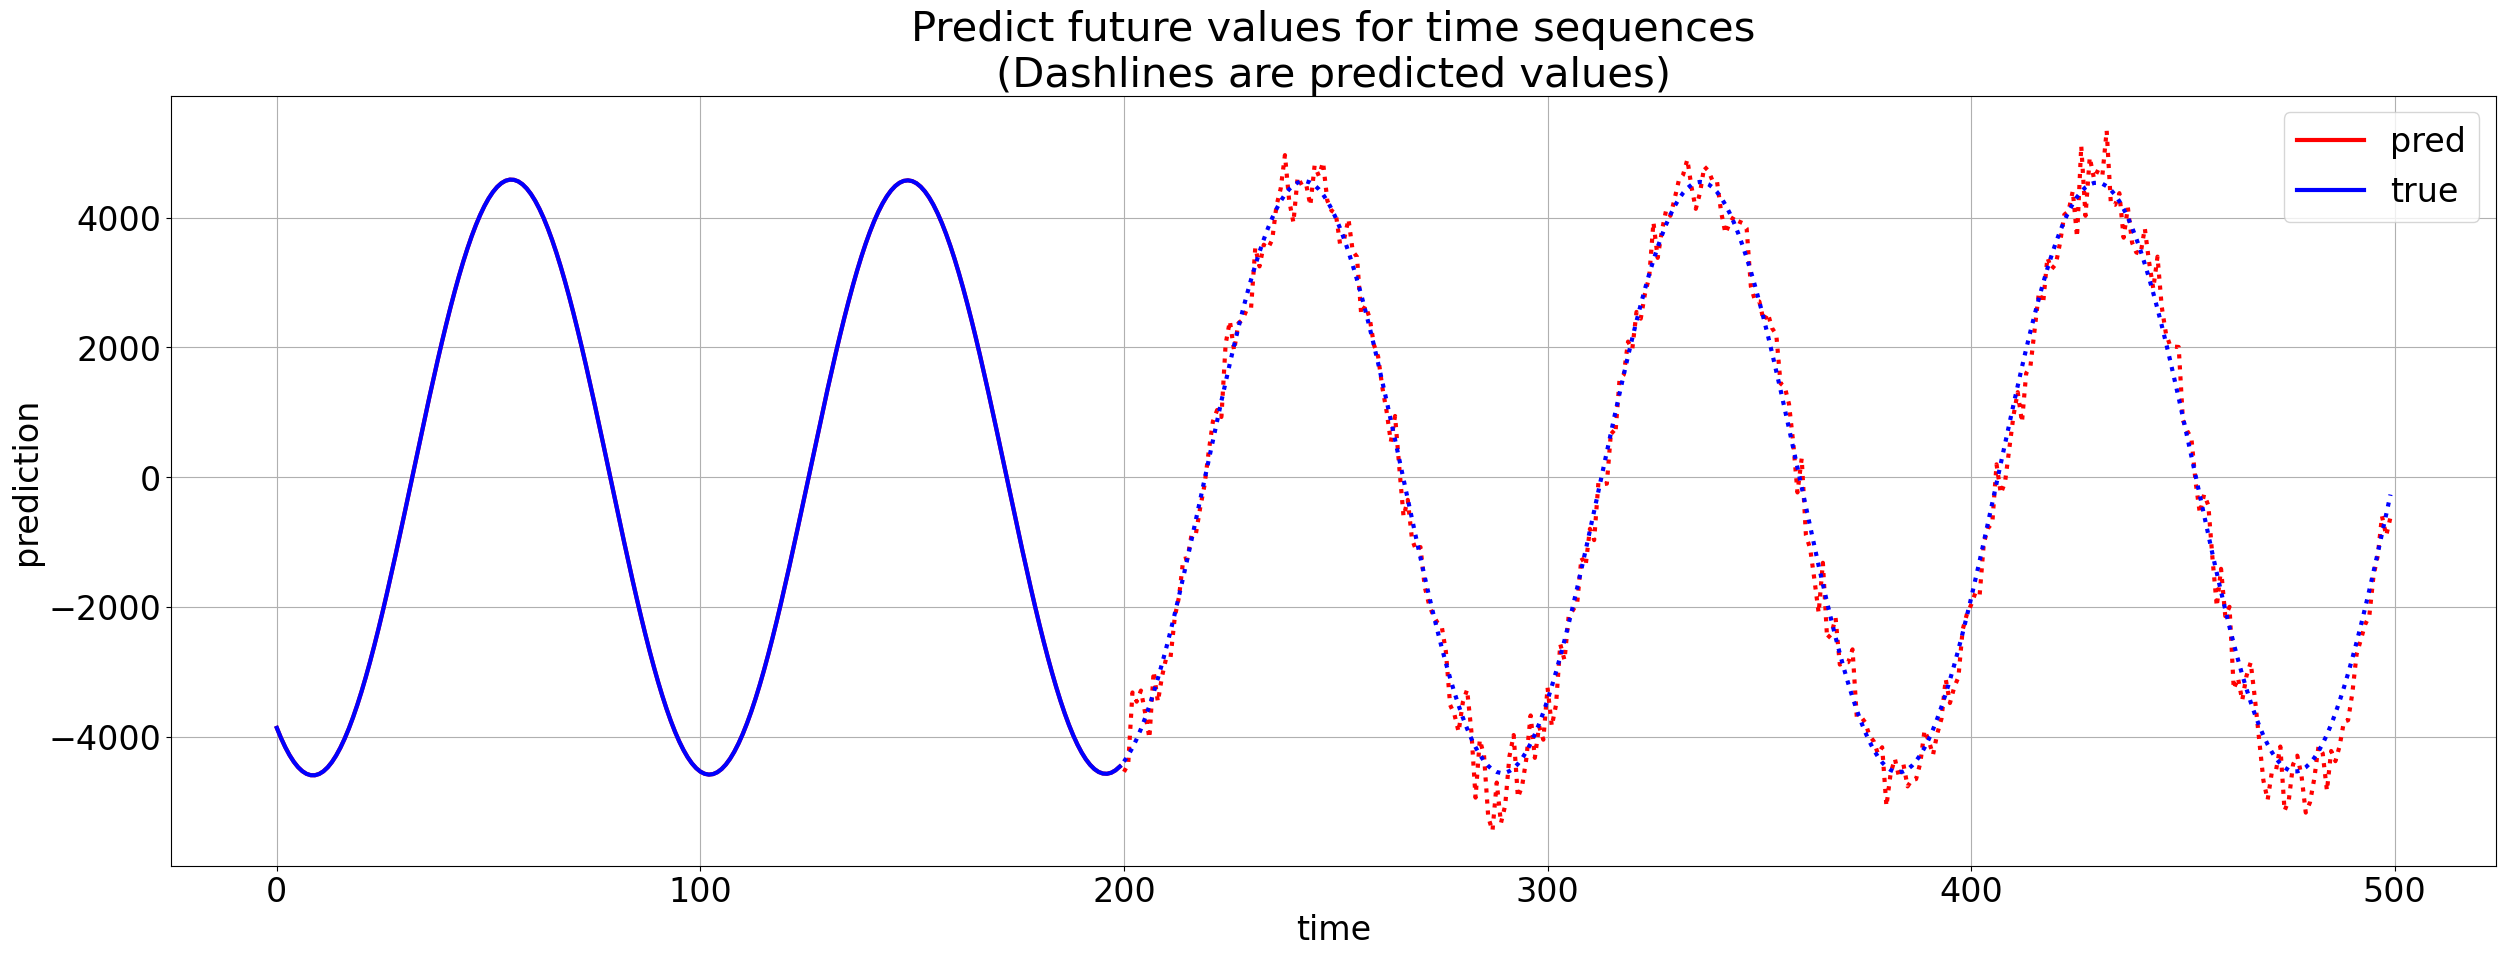

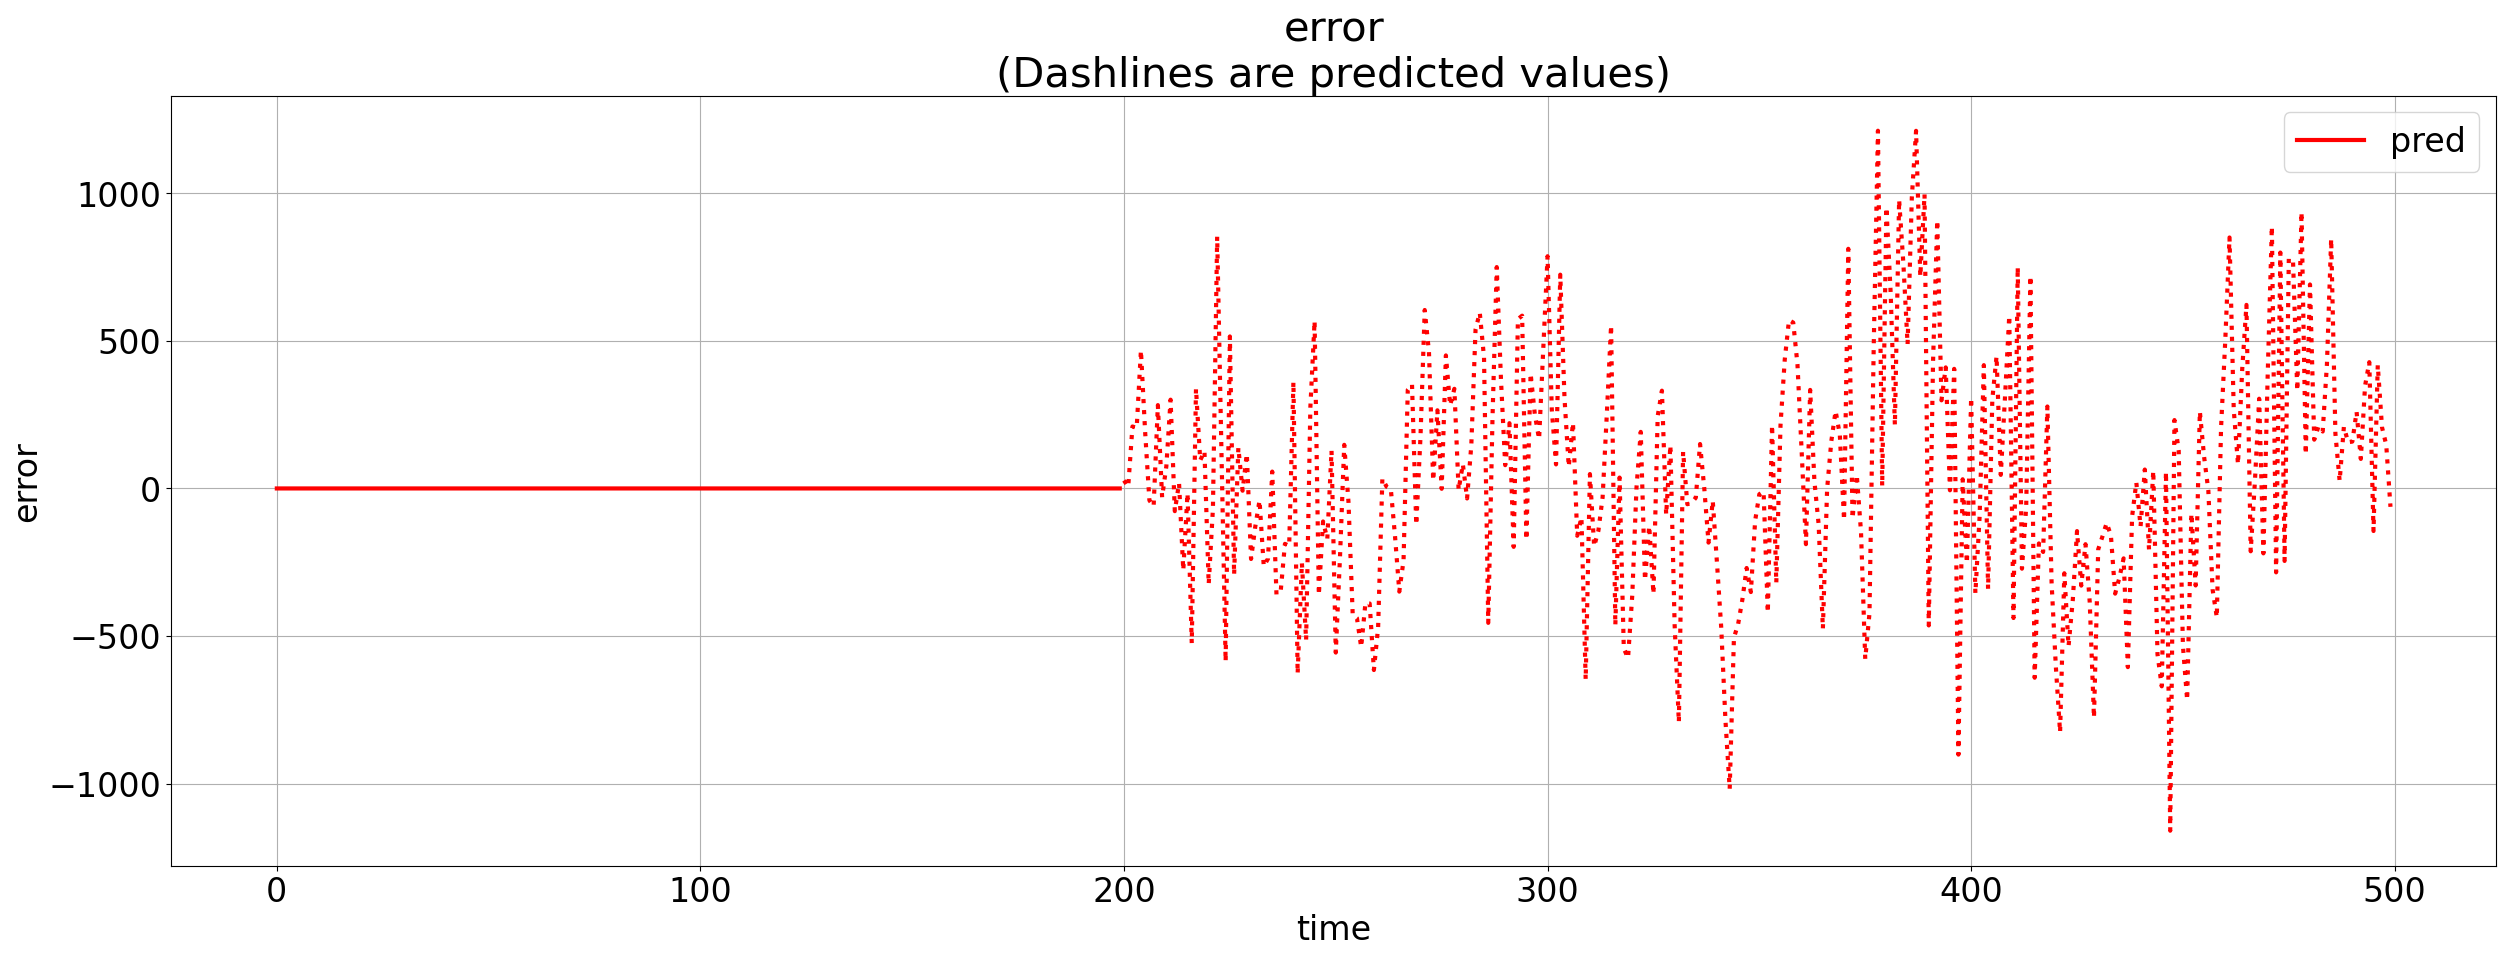

In [82]:
from datetime import datetime


# 直接指定保存的文件夹路径
folder = config['fig_path']  # 请替换为你的文件夹路径
fig_type = config['fig_type']
# draw predict
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('time', fontsize=24)
plt.ylabel('prediction', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
def draw(yi, color,label):
    plt.plot(np.arange(input.size(2)), yi[:input.size(2)], color, linewidth = 3.0, label=label)
    plt.plot(np.arange(input.size(2), input.size(2) + config['future']), yi[input.size(2):], color + ':', linewidth = 3.0)
draw(preds, 'r','pred')
# plt.plot(np.array(list(range(0,len(xx)))),xx, 'g', linewidth = 2.0)
draw(xx, 'b','true')
plt.legend(fontsize=24)
plt.grid(True)

pdf_filename = f"{folder}predict_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.{fig_type}"
plt.savefig(pdf_filename)
# plt.close()

# draw err
plt.figure(figsize=(30,10))
plt.title('error\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('time', fontsize=24)
plt.ylabel('error', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
def draw(yi, color,label):
    plt.plot(np.arange(input.size(2)), yi[:input.size(2)], color, linewidth = 3.0, label=label)
    plt.plot(np.arange(input.size(2), input.size(2) + config['future']), yi[input.size(2):], color + ':', linewidth = 3.0)
draw(error, 'r','pred')
plt.legend(fontsize=24)
plt.grid(True)

pdf_filename = f"{folder}error_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.{fig_type}"
plt.savefig(pdf_filename)
# plt.close()

## 异常检测

In [109]:
maximum = scores.max()
num_samples = 10
threshold = torch.linspace(0, maximum, num_samples)
idx_threshold = 8
print(scores.shape)
anomaly = (scores > threshold[idx_threshold]).float()
anomaly = np.array(anomaly)
print(anomaly.shape)
zeros_array = np.zeros(400)
print(zeros_array.shape)
anomaly_weight = np.concatenate((zeros_array, anomaly))

torch.Size([100])
(100,)
(400,)


### plot

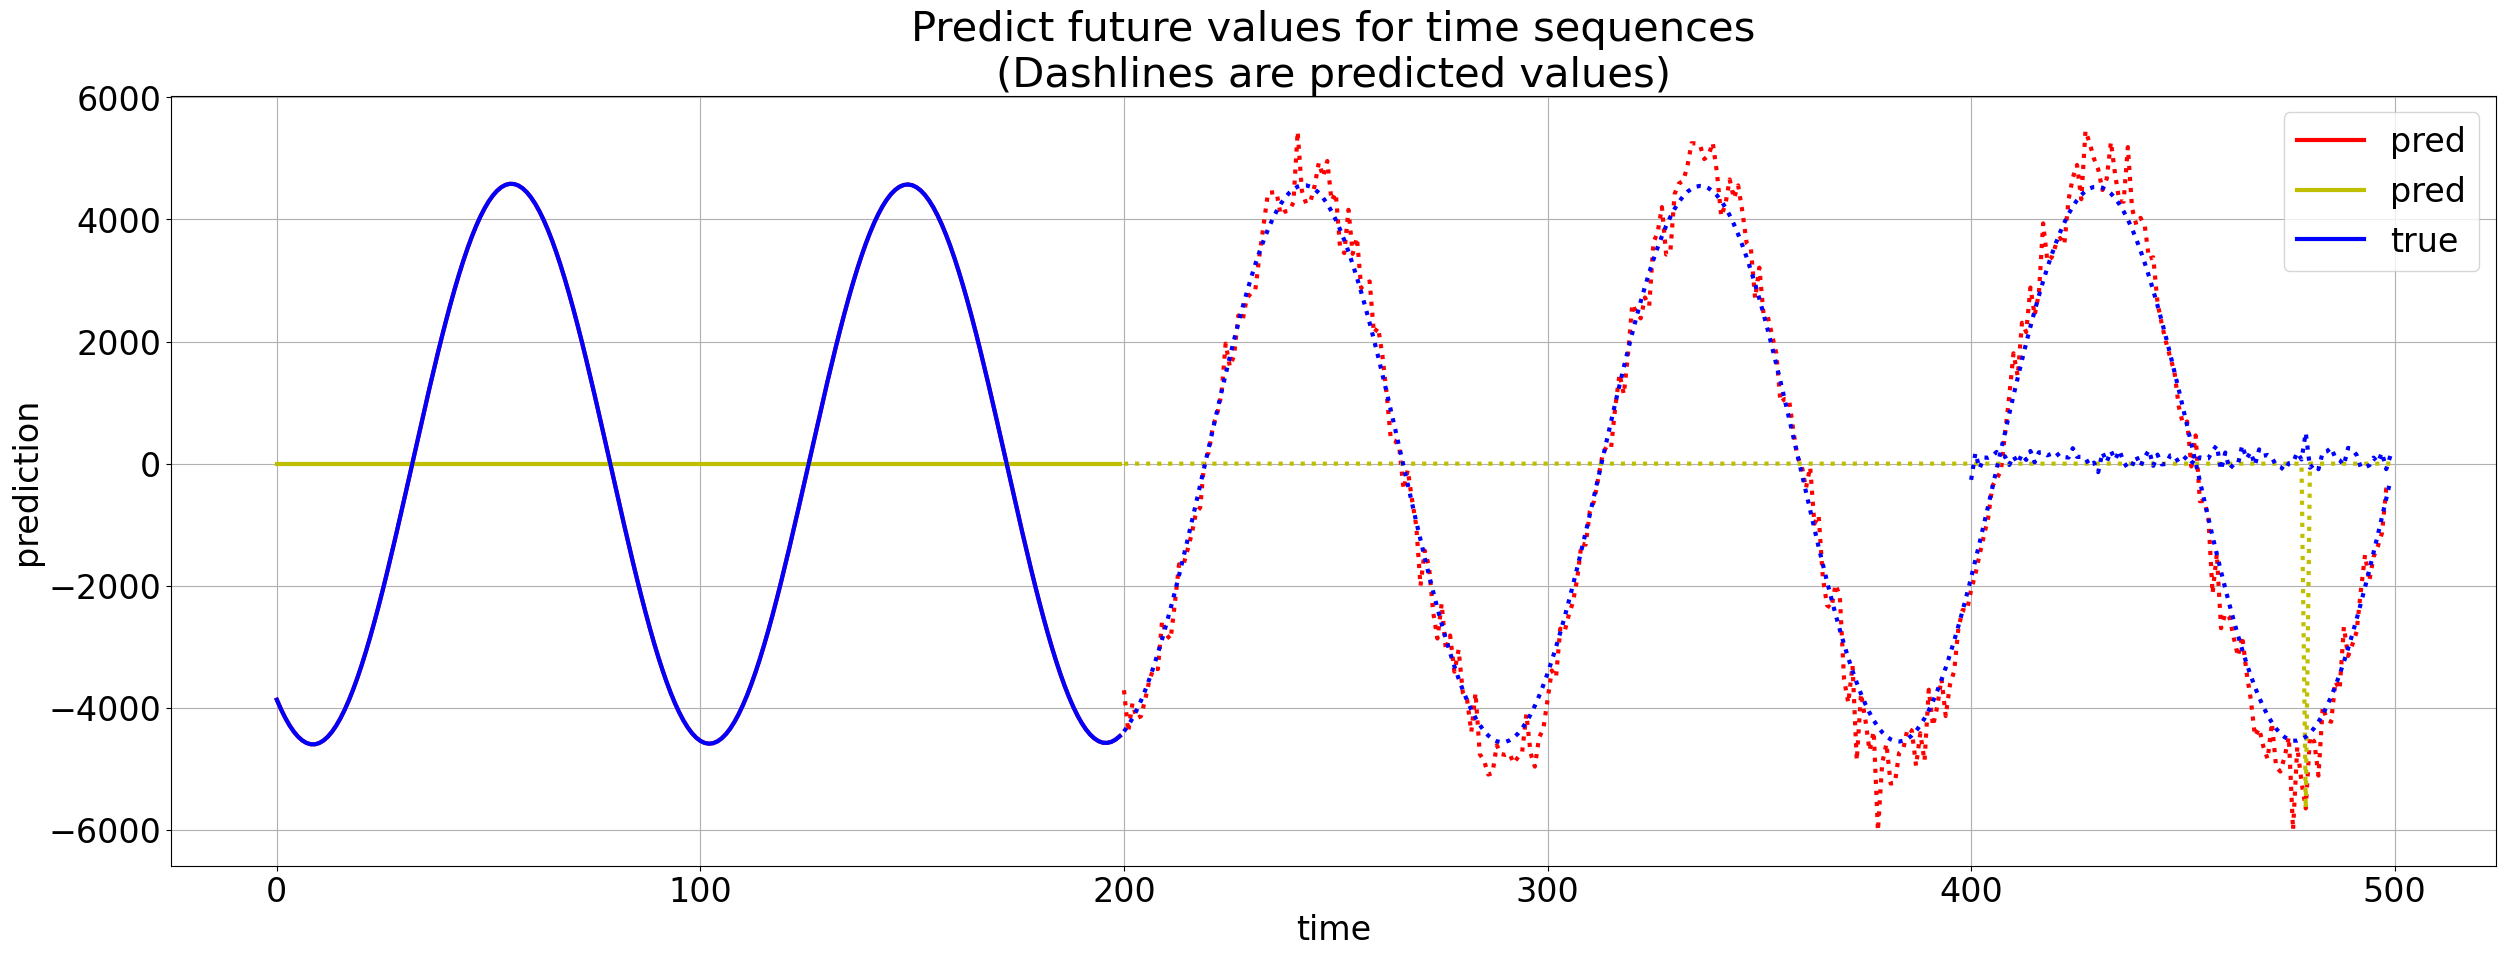

In [110]:
# 直接指定保存的文件夹路径
folder = config['fig_path']  # 请替换为你的文件夹路径
fig_type = config['fig_type']
# draw predict
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
plt.xlabel('time', fontsize=24)
plt.ylabel('prediction', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
def draw(yi, color,label,flag_all):
    if flag_all:
        plt.plot(np.arange(input.size(2)), yi[:input.size(2)], color, linewidth = 3.0, label=label)
        plt.plot(np.arange(input.size(2), input.size(2) + config['future']), yi[input.size(2):], color + ':', linewidth = 3.0)
    else:
        plt.plot(np.arange(input.size(2)+config['window_len'], input.size(2) + config['future']), yi, color + ':', linewidth = 3.0)
draw(preds, 'r','pred',1)
draw(preds*anomaly_weight, 'y','pred',1)
draw(xx, 'b','true',1)
draw(scores, 'b','true',0)

plt.legend(fontsize=24)
plt.grid(True)

# pdf_filename = f"{folder}ad_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.{fig_type}"
# plt.savefig(pdf_filename)

### 评估精度

In [84]:
def get_precision_recall(device, score, num_samples, beta=1.0, sampling='log', predicted_score=None):
    '''
    :param args:
    :param score: anomaly scores
    :param label: anomaly labels
    :param num_samples: the number of threshold samples
    :param beta:
    :param scale:
    :return:
    '''
    if predicted_score is not None:
        score = score - torch.FloatTensor(predicted_score).squeeze().to(device)

    maximum = score.max()
    if sampling=='log':
        # Sample thresholds logarithmically
        # The sampled thresholds are logarithmically spaced between: math:`10 ^ {start}` and: math:`10 ^ {end}`.
        th = torch.logspace(0, torch.log10(torch.tensor(maximum)), num_samples).to(device)
    else:
        # Sample thresholds equally
        # The sampled thresholds are equally spaced points between: attr:`start` and: attr:`end`
        th = torch.linspace(0, maximum, num_samples).to(device)

    precision = []
    recall = []

    for i in range(len(th)):
        anomaly = (score > th[i]).float()
        idx = anomaly * 2
        # idx = anomaly * 2 + label
        tn = (idx == 0.0).sum().item()  # tn
        fn = (idx == 1.0).sum().item()  # fn
        fp = (idx == 2.0).sum().item()  # fp
        tp = (idx == 3.0).sum().item()  # tp

        p = tp / (tp + fp + 1e-7)
        r = tp / (tp + fn + 1e-7)

        if p != 0 and r != 0:
            precision.append(p)
            recall.append(r)

    precision = torch.FloatTensor(precision)
    recall = torch.FloatTensor(recall)


    f1 = (1 + beta ** 2) * (precision * recall).div(beta ** 2 * precision + recall + 1e-7)

    return precision, recall, f1

In [85]:
precision, recall, f_beta = get_precision_recall(device, score, num_samples=1000, beta=config['param_beta'])


C:\Users\zps\AppData\Local\Temp\ipykernel_22904\2681073755.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  th = torch.logspace(0, torch.log10(torch.tensor(maximum)), num_samples).to(device)
